In [61]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import bias_correction

In [62]:
mildura_lat = -34.2
mildura_lon = 142.1

### Observations

In [82]:
txx_obs_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'

In [64]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [65]:
da_obs = ds_obs['tasmax'].sel({'lat': mildura_lat, 'lon': mildura_lon}, method='nearest')

In [66]:
da_obs = da_obs.compute()

In [67]:
df_obs = da_obs.to_dataframe()

In [68]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
1990-06-30 00:00:00 -34.0  142.0  1990-01-03  48.070168
1939-06-30 00:00:00 -34.0  142.0  1939-01-10  47.354195
2001-06-30 00:00:00 -34.0  142.0  2001-01-14  47.192989
2020-06-30 00:00:00 -34.0  142.0  2019-12-20  46.924156
2019-06-30 00:00:00 -34.0  142.0  2019-01-04  46.915867
1979-06-30 00:00:00 -34.0  142.0  1979-01-14  46.859818
2017-06-30 00:00:00 -34.0  142.0  2017-02-10  46.850529
2009-06-30 00:00:00 -34.0  142.0  2009-02-07  46.835129
1932-06-30 00:00:00 -34.0  142.0  1932-01-27  46.403103
1982-06-30 00:00:00 -34.0  142.0  1982-01-24  46.376907


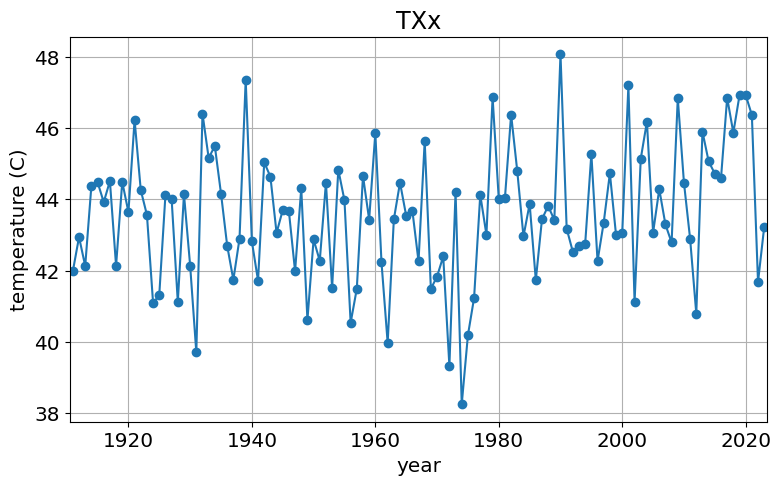

In [69]:
fig, ax = plt.subplots(figsize=[9, 5])
values = da_obs.values
years = da_obs['time'].dt.year.values
plt.plot(years, values, marker='o')
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.grid()

In [70]:
gev_shape_obs, gev_loc_obs, gev_scale_obs = eva.fit_gev(da_obs.values)
print(f'Shape parameter: {gev_shape_obs:.2f}')
print(f'Location parameter: {gev_loc_obs:.2f}')
print(f'Scale parameter: {gev_scale_obs:.2f}')

Shape parameter: 0.30
Location parameter: 42.93
Scale parameter: 1.89


### Model data

In [71]:
txx_model_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'

In [73]:
ds_model = fileio.open_dataset(txx_model_file)

In [74]:
da_model = ds_model['tasmax'].sel({'lat': -34.2, 'lon': 142.1}, method='nearest')

In [75]:
da_model = da_model.compute()

In [76]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [77]:
gev_shape_model, gev_loc_model, gev_scale_model = eva.fit_gev(da_model_stacked.values)
print(f'Shape parameter: {gev_shape_model:.2f}')
print(f'Location parameter: {gev_loc_model:.2f}')
print(f'Scale parameter: {gev_scale_model:.2f}')

Shape parameter: 0.25
Location parameter: 45.05
Scale parameter: 2.27


### Bias correction

#### Additive

In [78]:
bias_add = bias_correction.get_bias(
    da_model,
    da_obs,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [79]:
da_model_bc_add = bias_correction.remove_bias(da_model, bias_add, 'additive')

In [80]:
da_model_bc_add = da_model_bc_add.compute()

In [81]:
da_model_bc_add_stacked = da_model_bc_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [83]:
gev_shape_model_bc_add, gev_loc_model_bc_add, gev_scale_model_bc_add = eva.fit_gev(da_model_bc_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_add:.2f}')
print(f'Location parameter: {gev_loc_model_bc_add:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_add:.2f}')

Shape parameter: 0.25
Location parameter: 42.97
Scale parameter: 2.27


#### Multiplicative

In [84]:
bias_mulc = bias_correction.get_bias(
    da_model,
    da_obs,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [85]:
da_model_bc_mulc = bias_correction.remove_bias(da_model, bias_mulc, 'additive')
da_model_bc_mulc = da_model_bc_mulc.compute()

In [86]:
da_model_bc_mulc_stacked = da_model_bc_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [87]:
gev_shape_model_bc_mulc, gev_loc_model_bc_mulc, gev_scale_model_bc_mulc = eva.fit_gev(da_model_bc_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_bc_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_bc_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_bc_mulc:.2f}')

Shape parameter: 0.25
Location parameter: 44.00
Scale parameter: 2.27


## Comparison

In [56]:
similarity_ds = similarity.similarity_tests(da_model, da_obs)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.4875908
KS p-value: 4.6272845e-25
AD score: 81.58321
AD p-value: 0.001


/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [ ]:
similarity_ds = similarity.similarity_tests(da_model, da_obs)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

In [ ]:
similarity_ds = similarity.similarity_tests(da_model, da_obs)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

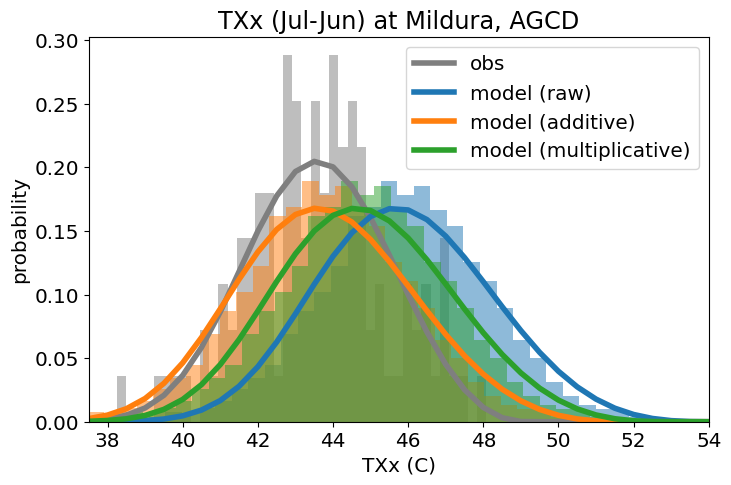

In [89]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(30, 65, 0.5)

da_obs.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.5)
gev_pdf_obs = gev.pdf(gev_xvals, gev_shape_obs, gev_loc_obs, gev_scale_obs)
plt.plot(gev_xvals, gev_pdf_obs, color='tab:gray', linewidth=4.0, label='obs')

da_model_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model = gev.pdf(gev_xvals, gev_shape_model, gev_loc_model, gev_scale_model)
plt.plot(gev_xvals, gev_pdf_model, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_bc_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_bc_add = gev.pdf(gev_xvals, gev_shape_model_bc_add, gev_loc_model_bc_add, gev_scale_model_bc_add)
plt.plot(gev_xvals, gev_pdf_model_bc_add, color='tab:orange', linewidth=4.0, label='model (additive)')

da_model_bc_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_bc_mulc = gev.pdf(gev_xvals, gev_shape_model_bc_mulc, gev_loc_model_bc_mulc, gev_scale_model_bc_mulc)
plt.plot(gev_xvals, gev_pdf_model_bc_mulc, color='tab:green', linewidth=4.0, label='model (multiplicative)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at Mildura, AGCD')
plt.xlim(37.5, 54)
plt.legend()
plt.show()

INFO:root:mean: Obs = 43.56737518310547, Model 95% CI =45.48113231658935 to 46.30500164031982
INFO:root:standard deviation: Obs = 1.8655565977096558, Model 95% CI =1.8866824805736542 to 2.5260673224925996
INFO:root:skew: Obs = -0.050572533160448074, Model 95% CI =-0.6983555525541305 to 0.41307817175984374
INFO:root:kurtosis: Obs = -0.05454087257385254, Model 95% CI =-0.600154060125351 to 1.76401035785675
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.30247233)
Coordinates:
    lat      float64 8B -34.0
    lon      float64 8B 142.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.16169254893499888 to 0.43796477503346165
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(42.92739216)
Coordinates:
    lat      float64 8B -34.0
    lon      fl

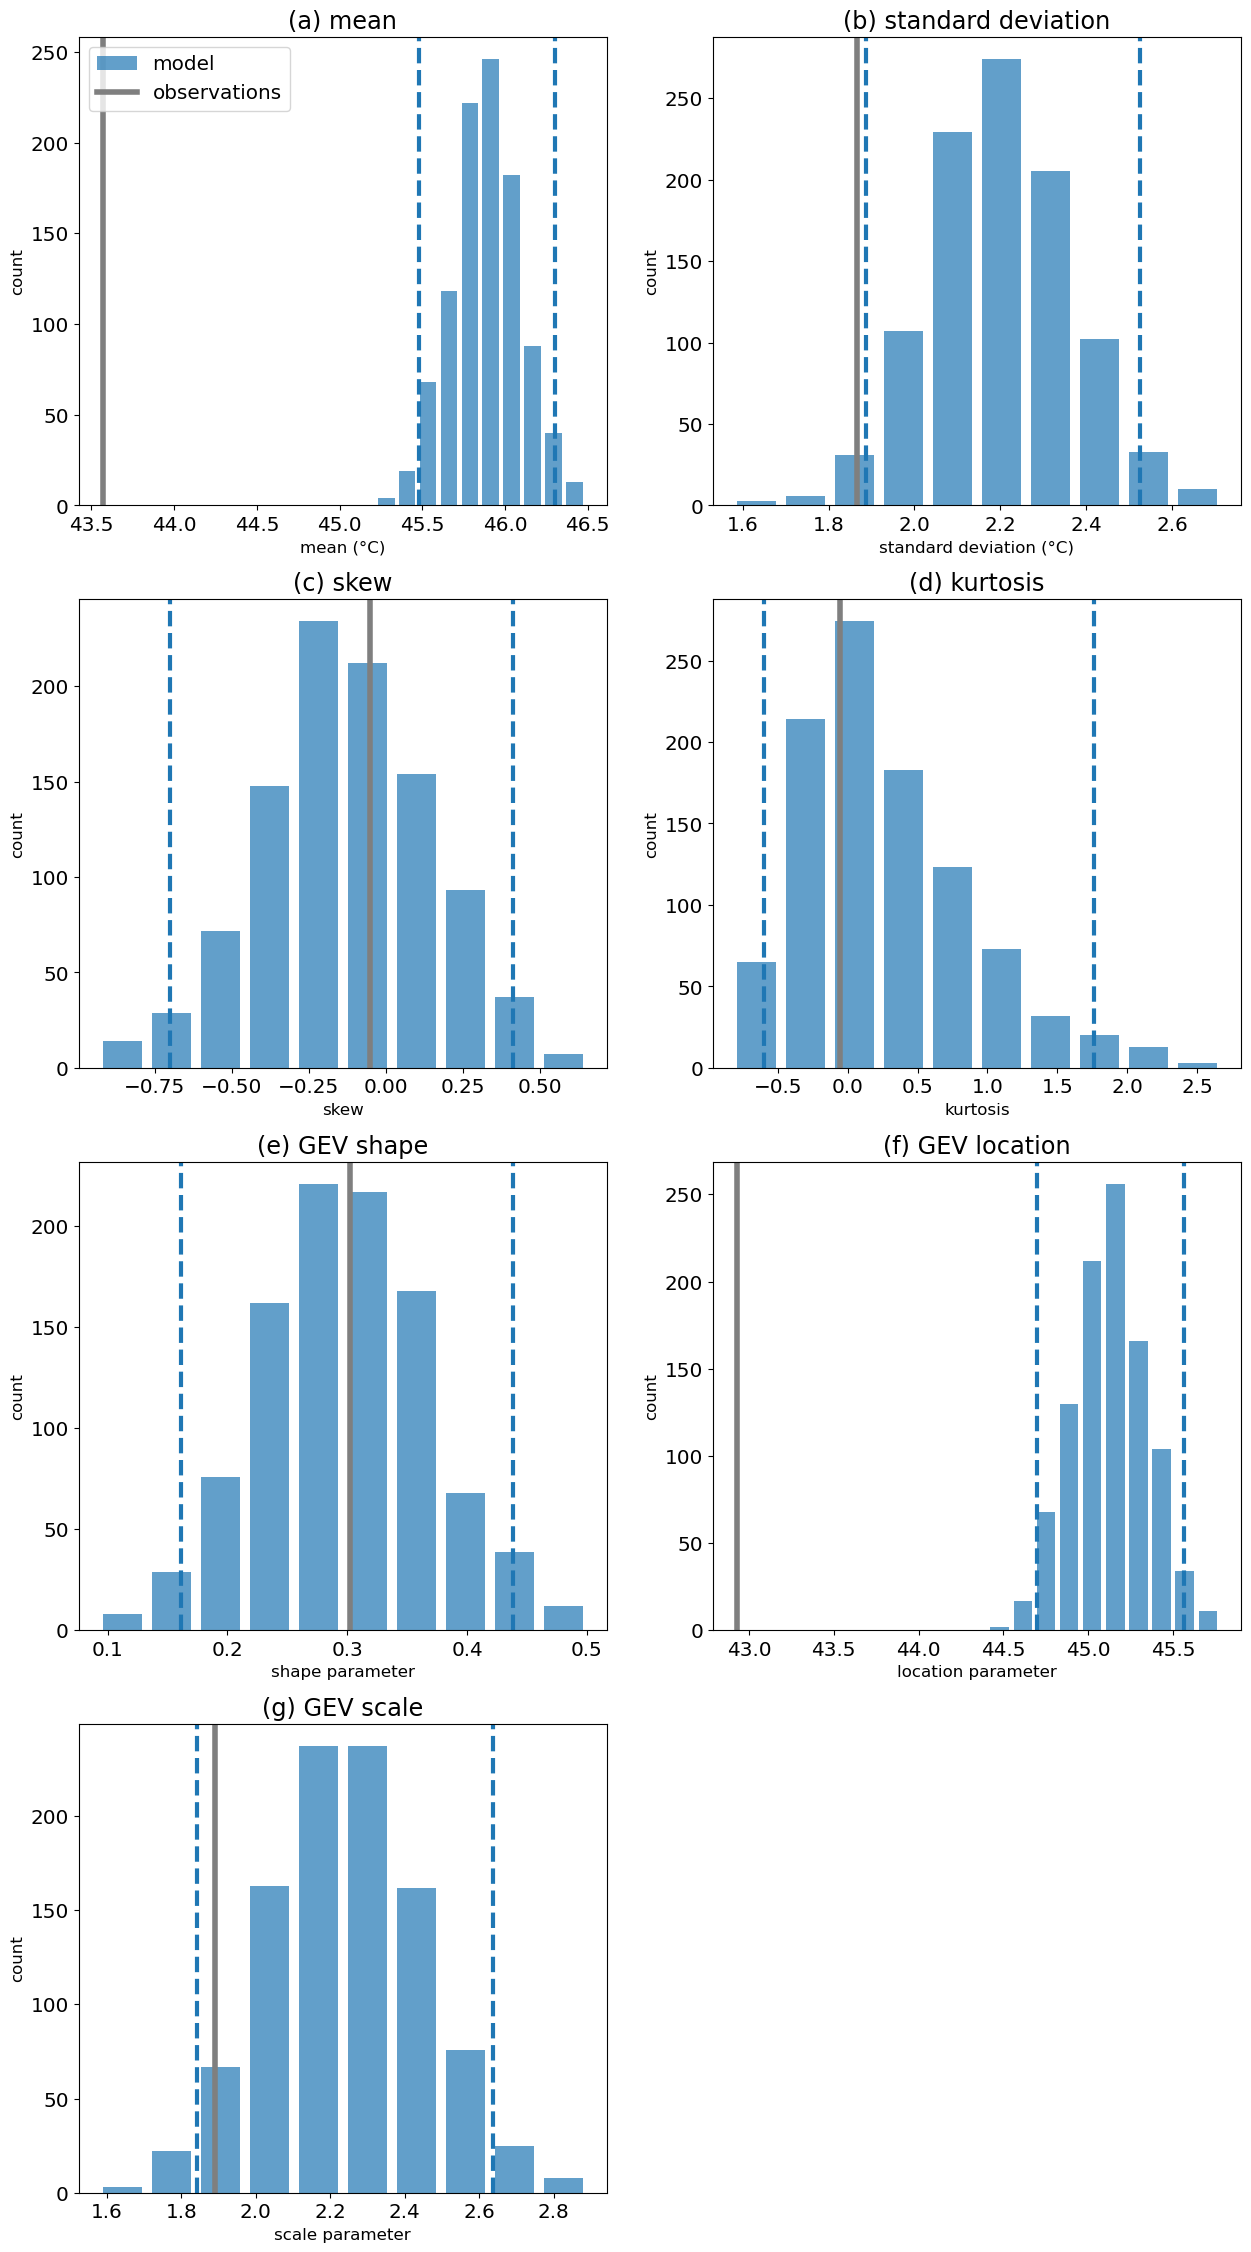

In [50]:
moments.create_plot(
    da_model,
    da_obs,
#    da_bc_fcst=model_da_bc,
)